In [1]:
import tradingWithPython.lib.yahooFinance as yahoo
import pandas as pd
from io import StringIO # this one is handy for for creating objects in memory that behave like files from disk

%pylab inline
%run common.py

Populating the interactive namespace from numpy and matplotlib


# Leveraged ETF backtest YTD

Many people think that leveraged etfs in the long term underperform their benchmarks. This is true for choppy markets, but not in the case of trending conditions, either up or down. Leverage only has effect on the *most likely* outcome, not on the *expected* outcome. For more background please read [this post](http://matlab-trading.blogspot.nl/2011/05/guess-what-leveraged-etfs-dont-decay.html)

2017/2018 has been a very interesting period, which trended up for most of the year 2018 and becoming choppy in early 2018. Let's see what would happen if we shorted some of the leveraged etfs a year ago and hedged them with their benchmark.

An overview of leveraged etfs can be found [here](http://etf.stock-encyclopedia.com/category/leveraged-etfs.html)


## Create pairs 
code below demonstrates a way of creating multiple pairs with a block of code that is easy to modify.  We could have just created all the pairs in code, which would be OK if we needed only a couple of pairs. With increasing number of pairs to simulate the code would become quickly bloated and unreadable. So for illustration purpose, the code below is split in pure data and parsing parts.
Each pair is a Series with two symbols and a multiplier. 

`SPY 2 SSO -1`  

for example means : pair consisting of 2\$ SPY and -1\$ of SSO  . Because SSO is a 2x leveraged etf we'll need to hedge it with 2x SPY position. 


In [2]:
# this is the data part
txt = """
SPY 2 SSO -1 
SPY -2 SDS -1
QQQ 2 QLD -1
QQQ -2 QID -1
IYF -2 SKF -1
"""

# parse data above. This code does not need modifications when we add or change pairs
s = StringIO(txt) # create file-like object from text above
pairs = [] # list of all pairs
symbols = [] # we'll use a set to keep a list of unique symbols 
for line in s.readlines():
    fields = line.split() # splits line into four fields 
    if not fields: continue # skip lines with no fields 
    
    symbols.append(fields[0]) # add first symbol
    symbols.append(fields[2]) # add second symbol
    pairs.append(pd.Series({fields[0]:int(fields[1]), fields[2]:int(fields[3]) })) # create a pair Series and add it
                                                                                   # to the 'pairs' list
print('Symbols: ', symbols)

#---get yahoo data
hData = yahoo.getHistoricData(symbols)
hData

Symbols:  ['SPY', 'SSO', 'SPY', 'SDS', 'QQQ', 'QLD', 'QQQ', 'QID', 'IYF', 'SKF']
 [*********************100%***********************]  10 of 10 complete

symbol         IYF                                                QID         \
ohlcv         open    high     low   close adj_close    volume   open   high   
Date                                                                           
1999-12-31     NaN     NaN     NaN     NaN       NaN       NaN    NaN    NaN   
2000-01-03     NaN     NaN     NaN     NaN       NaN       NaN    NaN    NaN   
2000-01-04     NaN     NaN     NaN     NaN       NaN       NaN    NaN    NaN   
2000-01-05     NaN     NaN     NaN     NaN       NaN       NaN    NaN    NaN   
2000-01-06     NaN     NaN     NaN     NaN       NaN       NaN    NaN    NaN   
...            ...     ...     ...     ...       ...       ...    ...    ...   
2018-03-27  118.09  118.46  115.13  115.84    115.84  4.01e+05  11.45  12.57   
2018-03-28  116.20  117.21  115.32  116.43    116.43  2.89e+05  12.50  12.84   
2018-03-29  117.14  118.43  116.57  117.81    117.81  1.85e+05  12.50  12.76   
2018-04-02  117.59  117.81  114.11  115.42    115.42  1.22e+06  12.37  13.15   
2018-04-03  115.91  117.05  115.33  116.81    116.81  3.69e+05  12.66  13.08   

symbol                      ...        SPY                               \
ohlcv         low  close    ...        low   close adj_close     volume   
Date                        ...                                           
1999-12-31    NaN    NaN    ...     146.25  146.88    104.42    3172700   
2000-01-03    NaN    NaN    ...     143.88  145.44    103.39    8164300   
2000-01-04    NaN    NaN    ...     139.64  139.75     99.35    8089800   
2000-01-05    NaN    NaN    ...     137.25  140.00     99.53   12177900   
2000-01-06    NaN    NaN    ...     137.75  137.75     97.93    6227200   
...           ...    ...    ...        ...     ...       ...        ...   
2018-03-27  11.44  12.38    ...     258.84  260.60    260.60  129941400   
2018-03-28  12.27  12.65    ...     258.58  259.83    259.83  146452300   
2018-03-29  11.94  12.19    ...     259.84  263.15    263.15  111601600   
2018-04-02  12.25  12.88    ...     254.67  257.47    257.47  186286300   
2018-04-03  12.49  12.60    ...     256.84  260.77    260.77  118151700   

symbol         SSO                                              
ohlcv         open    high     low   close adj_close    volume  
Date                                                            
1999-12-31     NaN     NaN     NaN     NaN       NaN       NaN  
2000-01-03     NaN     NaN     NaN     NaN       NaN       NaN  
2000-01-04     NaN     NaN     NaN     NaN       NaN       NaN  
2000-01-05     NaN     NaN     NaN     NaN       NaN       NaN  
2000-01-06     NaN     NaN     NaN     NaN       NaN       NaN  
...            ...     ...     ...     ...       ...       ...  
2018-03-27  107.72  108.20  101.80  103.16    103.16  5.70e+06  
2018-03-28  103.29  104.75  101.59  102.64    102.64  5.60e+06  
2018-03-29  103.60  106.82  102.93  105.48    105.48  2.65e+06  
2018-04-02  104.71  105.17   98.42  100.72    100.72  3.41e+06  
2018-04-03  101.73  103.62  100.15  103.22    103.22  2.91e+06  

[4592 rows x 48 columns]

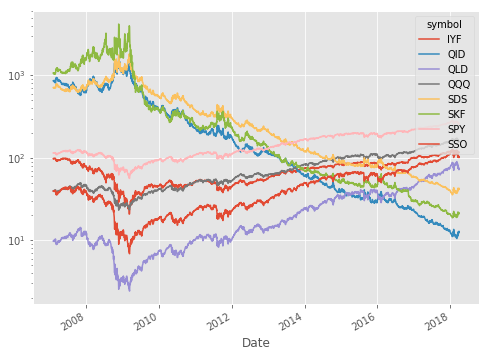

In [3]:
#plot data 
df_close = hData.xs('adj_close',axis=1,level=1).dropna()
df_close.plot(logy=True)

SPY    2
SSO   -1
dtype: int64


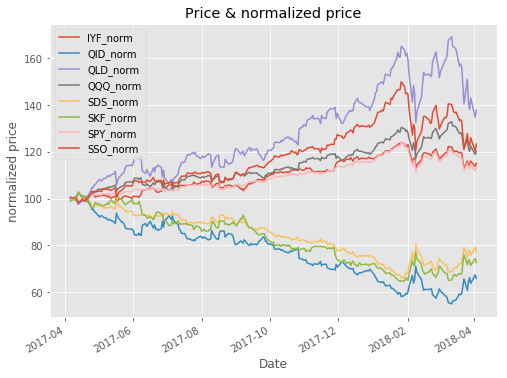

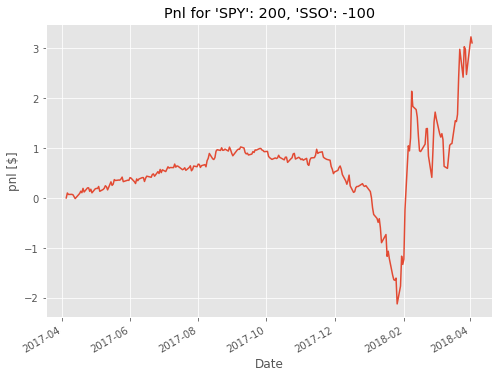

In [4]:
# simulate for one pair
pair = pairs[0]
print(pair)

price = df_close.tail(250)


# normalize prices
ret = price.pct_change().dropna()
priceNorm = (ret+1).cumprod()
priceNorm.columns = [c+'_norm' for c in price.columns] # add '_norm' to column names. 
(100*priceNorm).plot(ax=gca()) # plot to existing chart
title('Price & normalized price')
ylabel('normalized price')

#savefig('output/leveraged_pair.png')

figure()
shares = (pair*100)/price.iloc[0,:] # number of shares to hold 

port = (price*shares).sum(1)-100
port.plot()
title('Pnl for ' + str((100*pair).to_dict()).strip('{}')) 
ylabel('pnl [$]')

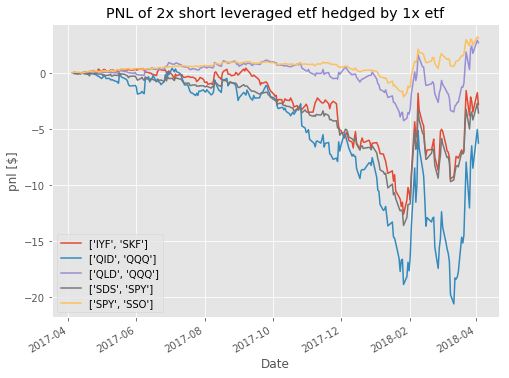

In [5]:
# simulate for all pairs

result = {} # dictionary to keep results in

for pair in pairs:

    price = df_close[pair.index].tail(250)
    price = price.dropna() # remove missing rows
    
    shares = (pair*100)/price.iloc[0,:]
    
    port = (price*shares).sum(1) # sum along rows
   
    result[str(pair.index.tolist())] = port  # save to dict

result = pd.DataFrame(result)  # convert to DataFrame
result -= result.iloc[0,:] # subtract capital at t=0

result.plot()

title('PNL of 2x short leveraged etf hedged by 1x etf')
ylabel('pnl [$]')

#savefig('output/leveraged_pnl.png')